# EPA1361 - Model-Based Decision Making
# Week 3 - Sensitivity analysis

This exercise uses the same predator-prey model we used for the multi-model exercise, focusing on the Python version. As with the other exercise, define a model object for the function below, with the uncertainty ranges provided:

|Parameter	|Range or value	        |
|-----------|--------------:|
|prey_birth_rate    	|0.015 – 0.035	|
|predation_rate|0.0005 – 0.003 	|
|predator_efficiency     	|0.001 – 0.004	    |
|predator_loss_rate	    |0.04 – 0.08	    |

* Sensitivity analysis often focuses on the final values of an outcome at the end of the simulation. However, we can also look at metrics that give us additional information about the behavior of the model over time. Using [the statsmodel library](https://www.statsmodels.org/stable/index.html) and an appropriate sampling design, fit a linear regression model for each of the following indicators. What can we conclude about the behavior of the model, and about the importance of the different inputs?

  * The final values of the _prey_ outcome
  * The mean values of the _prey_ outcome over time, within each experiment
  * The standard deviations of the _prey_ outcome over time, within each experiment
  

* Use the Sobol sampling functionality included in the Workbench to perform experiments with a sample size of N=50, then analyze the results with SALib for the same three indicators. This requires specifying the keyword argument `'uncertainty_sampling'` of perform_experiments. Note that when using Sobol sampling, the meaning of the keyword argument `scenarios` changes a bit. In order to properly estimate Sobol scores as well as interaction effects, you require N * (2D+2) scenarios, where D is the number of uncertain parameters, and N is the value for scenarios passed to `perform_experiments`. Repeat the analysis for larger sample sizes, with N=250 and N=1000. How can we interpret the first-order and total indices? Are these sample sizes sufficient for a stable estimation of the indices? You'll need to use the [get_SALib_problem](https://emaworkbench.readthedocs.io/en/latest/ema_documentation/em_framework/salib_samplers.html) function to convert your Workbench experiments to a problem definition that you can pass to the SALib analysis function. 

* *hint*: sobol is a deterministic sequence of quasi random numbers. Thus, you can run with N=1000 and simply slice for 1:50 and 1:250.

* Use the [Extra-Trees analysis](https://emaworkbench.readthedocs.io/en/latest/ema_documentation/analysis/feature_scoring.html) included in the Workbench to approximate the Sobol total indices, with a suitable sampling design. As a starting point, use an ensemble of 100 trees and a max_features parameter of 0.6, and set the analysis to regression mode. Are the estimated importances stable relative to the sample size and the analysis parameters? How do the results compare to the Sobol indices? For more details on this analysis see [Jaxa-Rozen & Kwakkel (2018)](https://www.sciencedirect.com/science/article/pii/S1364815217311581)

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from ema_workbench import (Model, MultiprocessingEvaluator, SequentialEvaluator, RealParameter, TimeSeriesOutcome, perform_experiments, ema_logging)

from ema_workbench.em_framework.evaluators import LHS, SOBOL, MORRIS

from ema_workbench.analysis import feature_scoring
from ema_workbench.analysis.scenario_discovery_util import RuleInductionType
from ema_workbench.em_framework.salib_samplers import get_SALib_problem
from SALib.analyze import sobol

def pred_prey1(prey_birth_rate=0.025, predation_rate=0.0015, predator_efficiency=0.002,
             predator_loss_rate=0.06, initial_prey=50, initial_predators=20, dt=0.25, 
             final_time=365, reps=1):

    #Initial values
    predators = np.zeros((reps, int(final_time/dt)+1))
    prey = np.zeros((reps, int(final_time/dt)+1))
    sim_time = np.zeros((reps, int(final_time/dt)+1))
    
    for r in range(reps):

        predators[r,0] = initial_predators
        prey[r,0] = initial_prey

    #Calculate the time series
    for t in range(0, sim_time.shape[1]-1):

        dx = (prey_birth_rate*prey[r,t]) - (predation_rate*prey[r,t]*predators[r,t])
        dy = (predator_efficiency*predators[r,t]*prey[r,t]) - (predator_loss_rate*predators[r,t])

        prey[r,t+1] = max(prey[r,t] + dx*dt, 0)
        predators[r,t+1] = max(predators[r,t] + dy*dt, 0)
        sim_time[r,t+1] = (t+1)*dt
    
    #Return outcomes
    return {'TIME':sim_time,
            'predators':predators,
            'prey':prey}

In [2]:
ema_logging.log_to_stderr(ema_logging.INFO)

# Setup the model
pred_prey = Model('PredPreyPy', function=pred_prey1)

pred_prey.uncertainties = [RealParameter('prey_birth_rate', 0.015, 0.035),
                       RealParameter('predation_rate', 0.0005, 0.003),
                      RealParameter('predator_efficiency', 0.0001, 0.004),
                      RealParameter('predator_loss_rate', 0.004, 0.08)]

pred_prey.outcomes = [TimeSeriesOutcome('TIME'),
                  TimeSeriesOutcome('predators'),
                  TimeSeriesOutcome('prey')]

In [3]:
from ema_workbench.em_framework.samplers import LHSSampler
from ema_workbench.em_framework.samplers import FullFactorialSampler as FFS

In [4]:
with SequentialEvaluator(pred_prey) as evaluator:
    experiment, outcomes = evaluator.perform_experiments(scenarios = 200, uncertainty_sampling=LHS)

[MainProcess/INFO] performing 200 scenarios * 1 policies * 1 model(s) = 200 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 20 cases completed
[MainProcess/INFO] 40 cases completed
[MainProcess/INFO] 60 cases completed
[MainProcess/INFO] 80 cases completed
[MainProcess/INFO] 100 cases completed
[MainProcess/INFO] 120 cases completed
[MainProcess/INFO] 140 cases completed
[MainProcess/INFO] 160 cases completed
[MainProcess/INFO] 180 cases completed
[MainProcess/INFO] 200 cases completed
[MainProcess/INFO] experiments finished


In [5]:
outcomes

{'TIME': array([[[0.0000e+00, 2.5000e-01, 5.0000e-01, ..., 3.6450e+02,
          3.6475e+02, 3.6500e+02]],
 
        [[0.0000e+00, 2.5000e-01, 5.0000e-01, ..., 3.6450e+02,
          3.6475e+02, 3.6500e+02]],
 
        [[0.0000e+00, 2.5000e-01, 5.0000e-01, ..., 3.6450e+02,
          3.6475e+02, 3.6500e+02]],
 
        ...,
 
        [[0.0000e+00, 2.5000e-01, 5.0000e-01, ..., 3.6450e+02,
          3.6475e+02, 3.6500e+02]],
 
        [[0.0000e+00, 2.5000e-01, 5.0000e-01, ..., 3.6450e+02,
          3.6475e+02, 3.6500e+02]],
 
        [[0.0000e+00, 2.5000e-01, 5.0000e-01, ..., 3.6450e+02,
          3.6475e+02, 3.6500e+02]]]),
 'predators': array([[[20.        , 19.98023245, 19.96009017, ..., 20.72589288,
          20.71986723, 20.71333827]],
 
        [[20.        , 20.11608759, 20.22948961, ...,  3.5958138 ,
           3.57799338,  3.56048153]],
 
        [[20.        , 20.46676725, 20.9400062 , ...,  2.67880906,
           2.65072796,  2.62307725]],
 
        ...,
 
        [[20.        ,

In [6]:
df = pd.DataFrame(outcomes['prey'][:,-1])
df['std'] = df.T.std()
df['last'] = df[1460]
df['mean'] = np.mean(df)

In [7]:
Y = df[['std', 'last', 'mean']]




In [8]:
from sklearn.preprocessing import StandardScaler
scale = StandardScaler()
X = experiment[['predation_rate', 'predator_efficiency', 'predator_loss_rate', 'prey_birth_rate']]
scaled_data = scale.fit_transform(X)
X = pd.DataFrame(X)
X

,predation_rate,predator_efficiency,predator_loss_rate,prey_birth_rate
0,0.001657,0.000824,0.045146,0.025469
1,0.002653,0.002018,0.077669,0.026565
2,0.002794,0.003303,0.071818,0.034957
3,0.002962,0.003588,0.039395,0.025599
4,0.002332,0.003488,0.072259,0.025695
...,...,...,...,...
195,0.002251,0.000862,0.053252,0.019792
196,0.002034,0.001169,0.069699,0.034064
197,0.001896,0.002453,0.067386,0.018934
198,0.001618,0.002383,0.045751,0.026670


In [9]:
from statsmodels.regression.linear_model import OLS

In [10]:
regression_model = OLS(Y['std'], scaled_data).fit()
regression_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                    std   R-squared (uncentered):                   0.149
Model:                            OLS   Adj. R-squared (uncentered):              0.132
Method:                 Least Squares   F-statistic:                              8.575
Date:                Mon, 10 May 2021   Prob (F-statistic):                    2.14e-06
Time:                        15:04:00   Log-Likelihood:                         -1109.6
No. Observations:                 200   AIC:                                      2227.
Df Residuals:                     196   BIC:                                      2240.
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -4.8477      4.513     -1.074      0.284     -13.748       4.053
x2           -22.7991      4.455     -5.118      0.000     -31.585     -14.013
x3             9.8702      4.517      2.185      0.030       0.963      18.777
x4             0.9524      4.527      0.210      0.834      -7.976       9.881
==============================================================================
Omnibus:                      298.372   Durbin-Watson:                   1.595
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            32556.429
Skew:                           6.784   Prob(JB):                         0.00
Kurtosis:                      64.014   Cond. No.                         1.25
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [11]:
regression_model = OLS(Y['mean'], scaled_data).fit()
regression_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                   mean   R-squared (uncentered):                   0.003
Model:                            OLS   Adj. R-squared (uncentered):             -0.017
Method:                 Least Squares   F-statistic:                             0.1613
Date:                Mon, 10 May 2021   Prob (F-statistic):                       0.958
Time:                        15:04:00   Log-Likelihood:                         -974.44
No. Observations:                 200   AIC:                                      1957.
Df Residuals:                     196   BIC:                                      1970.
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.6015      2.297     -0.262      0.794      -5.131       3.928
x2             1.3858      2.267      0.611      0.542      -3.085       5.857
x3             0.7043      2.298      0.306      0.760      -3.828       5.237
x4             0.7104      2.304      0.308      0.758      -3.833       5.254
==============================================================================
Omnibus:                       30.646   Durbin-Watson:                   0.006
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               23.448
Skew:                           0.733   Prob(JB):                     8.10e-06
Kurtosis:                       2.183   Cond. No.                         1.25
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [12]:
regression_model = OLS(Y['last'], scaled_data).fit()
regression_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                   last   R-squared (uncentered):                   0.248
Model:                            OLS   Adj. R-squared (uncentered):              0.233
Method:                 Least Squares   F-statistic:                              16.15
Date:                Mon, 10 May 2021   Prob (F-statistic):                    1.90e-11
Time:                        15:04:01   Log-Likelihood:                         -1112.6
No. Observations:                 200   AIC:                                      2233.
Df Residuals:                     196   BIC:                                      2246.
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.4151      4.583      0.309      0.758      -7.624      10.454
x2           -31.2672      4.524     -6.911      0.000     -40.189     -22.345
x3            16.2368      4.587      3.540      0.000       7.191      25.282
x4            -0.3453      4.598     -0.075      0.940      -9.413       8.722
==============================================================================
Omnibus:                      255.510   Durbin-Watson:                   1.344
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            14948.691
Skew:                           5.359   Prob(JB):                         0.00
Kurtosis:                      43.975   Cond. No.                         1.25
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [39]:
with SequentialEvaluator(pred_prey) as evaluator:
    experiment_SOBOL, outcomes_SOBOL = evaluator.perform_experiments(scenarios = 1000, uncertainty_sampling=SOBOL)

[MainProcess/INFO] performing 10000 scenarios * 1 policies * 1 model(s) = 10000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] 4000 cases completed
[MainProcess/INFO] 5000 cases completed
[MainProcess/INFO] 6000 cases completed
[MainProcess/INFO] 7000 cases completed
[MainProcess/INFO] 8000 cases completed
[MainProcess/INFO] 9000 cases completed
[MainProcess/INFO] 10000 cases completed
[MainProcess/INFO] experiments finished


In [71]:
df_SOBOL1 = pd.DataFrame(outcomes_SOBOL['prey'][:,-1])
df_SOBOL['std'] = df_SOBOL1.T.std()
df_SOBOL['last'] = df_SOBOL1[df_SOBOL1.columns[-1]]
df_SOBOL['mean'] = np.mean(df_SOBOL1, axis=1)
Y_SOBOL = df_SOBOL[['std', 'last', 'mean']]

X_SOBOL = experiment_SOBOL[['predation_rate', 'predator_efficiency', 'predator_loss_rate', 'prey_birth_rate']]


In [72]:
Y_SOBOL

,std,last,mean
0,38.879276,46.294667,91.657477
1,36.769655,47.377840,91.500101
2,15.341485,1.119070,11.049842
3,16.728086,7.925863,12.682249
4,42.757284,63.850175,89.105454
...,...,...,...
9995,16.666386,18.985912,12.579513
9996,16.113459,1.288684,12.845994
9997,6.974374,0.016880,1.582291
9998,15.776359,9.199366,11.470510


In [73]:
SA_lib_problem = get_SALib_problem(pred_prey.uncertainties)

In [74]:
SA_lib_problem 

{'num_vars': 4,
 'names': ['predation_rate',
  'predator_efficiency',
  'predator_loss_rate',
  'prey_birth_rate'],
 'bounds': [(0.0005, 0.003), (0.0001, 0.004), (0.004, 0.08), (0.015, 0.035)]}

In [76]:
Si = sobol.analyze(SA_lib_problem, Y_SOBOL['mean'].to_numpy())

In [77]:
Si

{'S1': array([-0.00108082,  0.68774238,  0.13741031,  0.00330385]),
 'S1_conf': array([0.00462566, 0.2047529 , 0.056836  , 0.00497944]),
 'ST': array([0.00236443, 0.97103156, 0.32051627, 0.00964812]),
 'ST_conf': array([0.00101412, 0.18989005, 0.11397274, 0.00360232]),
 'S2': array([[        nan, -0.00076177,  0.00205572,  0.00317364],
        [        nan,         nan,  0.2792488 ,  0.03221069],
        [        nan,         nan,         nan, -0.0396685 ],
        [        nan,         nan,         nan,         nan]]),
 'S2_conf': array([[       nan, 0.02067209, 0.00570695, 0.00626396],
        [       nan,        nan, 0.44912905, 0.35827943],
        [       nan,        nan,        nan, 0.08956162],
        [       nan,        nan,        nan,        nan]])}

In [78]:
scores_filtered = {k:Si[k] for k in ['ST', 'ST_conf', 'S1', 'S1_conf']}
scores_filtered

{'ST': array([0.00236443, 0.97103156, 0.32051627, 0.00964812]),
 'ST_conf': array([0.00101412, 0.18989005, 0.11397274, 0.00360232]),
 'S1': array([-0.00108082,  0.68774238,  0.13741031,  0.00330385]),
 'S1_conf': array([0.00462566, 0.2047529 , 0.056836  , 0.00497944])}

In [79]:
Si_df = pd.DataFrame(scores_filtered, index= SA_lib_problem['names'])
Si_df

,ST,ST_conf,S1,S1_conf
predation_rate,0.002364,0.001014,-0.001081,0.004626
predator_efficiency,0.971032,0.189890,0.687742,0.204753
predator_loss_rate,0.320516,0.113973,0.137410,0.056836
prey_birth_rate,0.009648,0.003602,0.003304,0.004979


In [80]:
sns.set_style('white')

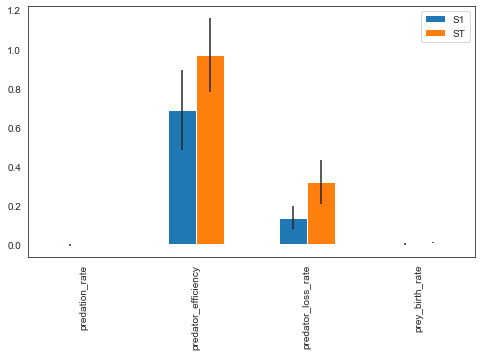

In [81]:
fig, ax = plt.subplots(1)
indices = Si_df[['S1', 'ST']]
err = Si_df[['S1_conf', 'ST_conf']]
indices.plot.bar(yerr=err.values.T, ax=ax)
fig.set_size_inches(8,6)
fig.subplots_adjust(bottom=0.3)

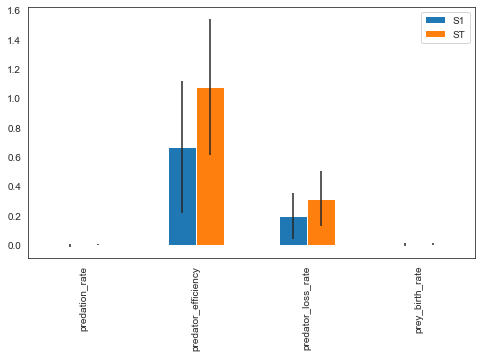

In [89]:
Si = sobol.analyze(SA_lib_problem, Y_SOBOL['mean'].to_numpy()[:2500])
scores_filtered = {k:Si[k] for k in ['ST', 'ST_conf', 'S1', 'S1_conf']}
Si_df = pd.DataFrame(scores_filtered, index= SA_lib_problem['names'])

fig, ax = plt.subplots(1)
indices = Si_df[['S1', 'ST']]
err = Si_df[['S1_conf', 'ST_conf']]
indices.plot.bar(yerr=err.values.T, ax=ax)
fig.set_size_inches(8,6)
fig.subplots_adjust(bottom=0.3)

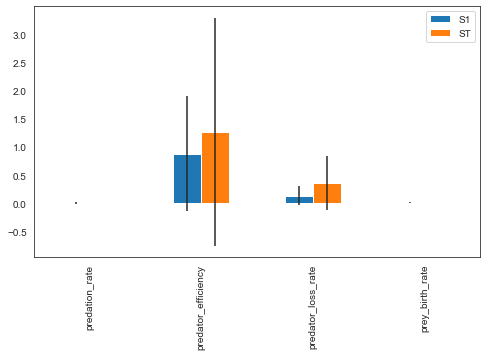

In [88]:
Si = sobol.analyze(SA_lib_problem, Y_SOBOL['mean'].to_numpy()[:500])
scores_filtered = {k:Si[k] for k in ['ST', 'ST_conf', 'S1', 'S1_conf']}
Si_df = pd.DataFrame(scores_filtered, index= SA_lib_problem['names'])

fig, ax = plt.subplots(1)
indices = Si_df[['S1', 'ST']]
err = Si_df[['S1_conf', 'ST_conf']]
indices.plot.bar(yerr=err.values.T, ax=ax)
fig.set_size_inches(8,6)
fig.subplots_adjust(bottom=0.3)